In [56]:
import scipy
import numpy as np
import json
import glob
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from bisect import bisect_left
import statsmodels.api as sm
import os
from analysis_pkg.analysis.ranking import rank_by_total_wins
import pickle as pkl

def load_bpod_data(dpath):
    with open(dpath, 'r') as file:
        data = json.load(file)
    return data

def take_closest(array1, array2):
    """
    Assumes array1 is sorted. Returns closest stamps to the given array2.

    If two numbers are equally close, return the smallest number.
    """
    msAlignedIndex = []
    for bpod_stamp in array2:
        pos = bisect_left(array1, bpod_stamp)
        if pos == 0:
            return array1[0]
        if pos == len(array1):
            return array1[-1]
        before = array1[pos - 1]
        after = array1[pos]
        if after - bpod_stamp < bpod_stamp - before:
            msAlignedIndex.append(np.where(array1 ==after))
        else:
            msAlignedIndex.append(np.where(array1 ==before))
    return np.squeeze(np.array(msAlignedIndex))
    
def get_state_time(state, bpod_data, trialnumbers=None):
    """
    Input a state name and bpod_data. Return the time stamp of the state(relative to trial start)
    """
    onsets = []

    if trialnumbers is not None:
        for trialnumber in trialnumbers:
            trial = bpod_data["SessionData"]['RawEvents']['Trial'][trialnumber]
            if type(trial['States'][state]) != float:
                onsets.append(trial['States'][state][0])
            else:
                onsets.append(trial['States'][state])
    else:
        for trial in bpod_data["SessionData"]['RawEvents']['Trial']:
            if type(trial['States'][state][0]) != float:
                onsets.append(np.squeeze(trial['States'][state][0]))
            else:
                onsets.append(np.squeeze(trial['States'][state])[0])
    return np.array(onsets)
    
def get_event_time(event, bpod_data, trialnumbers=None):
    """
    Input a event name and bpod_data. Return the time stamp of the event(relative to trial start)
    """
    onsets = []

    ### Get the events' onsets for the indicated trials
    if trialnumbers is not None:
        for trialnumber in trialnumbers:
            trial = bpod_data["SessionData"]['RawEvents']['Trial'][trialnumber]
            if type(trial['Events'][event]) != float:
                onsets.append(trial['Events'][event][0])
            else:
                onsets.append(trial['Events'][event])

    ### Get the events' onsets for all trials
    else:
        for trial in bpod_data["SessionData"]['RawEvents']['Trial']:
            if not trial['event']['WrongPort'][0]:
                if type(trial['States'][event][0]) != float:
                    onsets.append(np.squeeze(trial['Events'][event][0])[0])
                else:
                    onsets.append(np.squeeze(trial['Events'][event])[0])
    return np.array(onsets)

def get_RPE_neuron_activities(trialRewards, calcium_activities, calcium_baselines):
    """Select RPE relative neurons using the method from Muller. 2024 """
    RPE_neurons = []
    RPE_neurons_id = []
    for i, singleNeuronActivity in enumerate(calcium_activities):
        model = sm.OLS(singleNeuronActivity, trialRewards).fit()
        if model.pvalues < 0.005:
            # print(singleNeuronActivity)
            # print(calcium_baselines[i])
            # print(singleNeuronActivity-calcium_baselines[i])
            RPE_neurons.append(singleNeuronActivity-calcium_baselines[i])
            RPE_neurons_id.append(i)
    return np.array(RPE_neurons), np.array(RPE_neurons_id)

def mean_across_events(events, raw_neural_activities, fps=30, duration=2):  
    sum_acitivities = np.zeros((raw_neural_activities.shape[0],duration*2*fps))
    for event in events:
        raw_neural_activities_cue_onset = np.array(raw_neural_activities[:, event-duration*fps:event+duration*fps])
        sum_acitivities = raw_neural_activities_cue_onset + sum_acitivities
    return sum_acitivities/len(events)

def z_score(data, axis=1):
    return (data-data.mean(axis=axis, keepdims=True))/data.std(axis=axis, keepdims=True)

### Single mouse data load

In [24]:
mouse = 'ZZ0025-L'
date = '2024-12-12' # Remember to load corresponding bpod data

### load wavesurfer stamps
ms_stamps = np.squeeze(scipy.io.loadmat(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/ws_data/processed/{mouse}/{mouse}_{date}_ms.mat")['ms_frames_samplingstamps'])
bpod_trialstart_stamps = np.squeeze(scipy.io.loadmat(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/ws_data/processed/{mouse}/{mouse}_{date}_bpod.mat")['bpod_trialstart_samplingstamps'])

### load bpod results
bpod_data = load_bpod_data('/Users/fgs/HMLworkplace/Arena_analysis/Data/bpod_data/ZZ0025-L/ZZ0025-L_unity_stage3test_v1_20241212_141130.json')
try:
    trialRewards = np.array(bpod_data["SessionData"]['TrialRewards'])
except KeyError as e:
    print(f"No field:{e}")

### Exclude wrong trials
wrongTrials = []
for i, trial in enumerate(bpod_data['SessionData']['RawEvents']['Trial']):
    if trial['States']['WrongPort'][0]:
        wrongTrials.append(i)
trialRewards = np.delete(trialRewards, wrongTrials)

### load minian results
minian_results = xr.open_dataset(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/minian_data/{mouse}_{date}.netcdf")

In [25]:
bpod_data['SessionData']['RawData']['']

KeyError: ''

In [15]:
rewardTimes = get_state_time('Reward', bpod_data)
FS = 20000
FPS = 30
CLUSTER_WND = 3

raw_neural_activities = minian_results.C

ws_rewardTimes = rewardTimes*FS + bpod_trialstart_stamps
ms_rewadTimes= take_closest(ms_stamps, ws_rewardTimes)

z_scored_mean_neural_activities_rewards = z_score(mean_across_events(ms_rewadTimes, raw_neural_activities, duration=CLUSTER_WND))

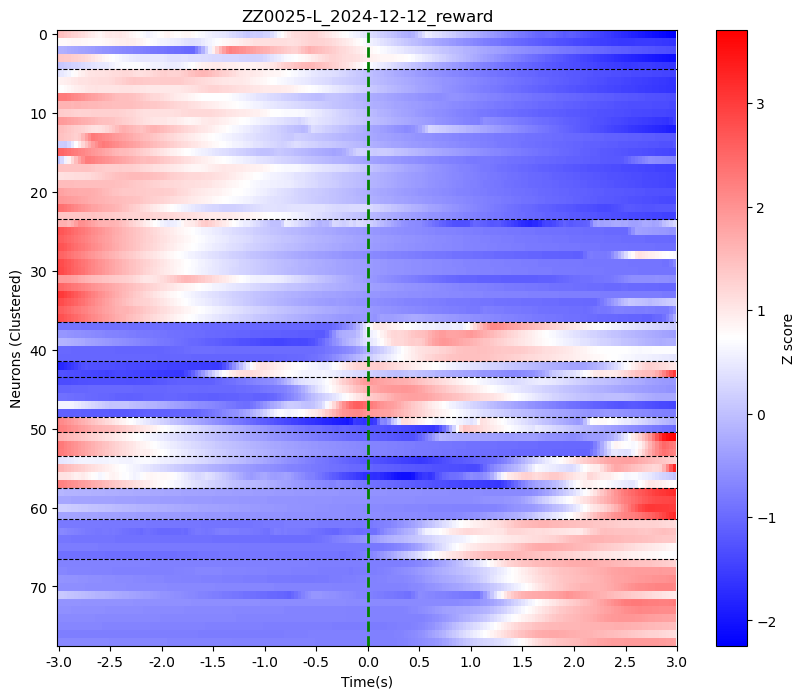

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

data_tobe_clustered = z_scored_mean_neural_activities_rewards

# Compute the distance matrix and perform hierarchical clustering
distance_matrix = pdist(data_tobe_clustered, metric='euclidean')
linkage_matrix = linkage(distance_matrix, method='ward')

# Get cluster labels
threshold = 15 # Adjust based on your dendrogram
clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# Reorder data by cluster labels
sorted_indices = np.argsort(clusters)  # Sort neurons by their cluster labels
data_sorted = data_tobe_clustered[sorted_indices]  # Reorder rows based on clustering

# Plot the heatmap
time_range = (-CLUSTER_WND,CLUSTER_WND,CLUSTER_WND*2*FPS)
plt.figure(figsize=(10, 8))
plt.imshow(data_sorted, aspect='auto', cmap='bwr', interpolation='nearest')
plt.colorbar(label='Z score')
plt.xticks(ticks=np.linspace(0, data_tobe_clustered.shape[1], 4*CLUSTER_WND+1), labels=np.linspace(-CLUSTER_WND, CLUSTER_WND,4*CLUSTER_WND+1))
# Add dashed lines to distinguish clusters
unique_clusters = np.unique(clusters)
for i in range(1, len(unique_clusters)):
    cluster_end = np.where(clusters[sorted_indices] == unique_clusters[i - 1])[0][-1]
    plt.axhline(y=cluster_end + 0.5, color='black', linestyle='--', linewidth=0.8)
plt.axvline(x=CLUSTER_WND*FPS, color="green", linestyle="--", linewidth=2, label="Vertical Line")
plt.title(f"{mouse}_{date}_reward")
plt.xlabel("Time(s)")
plt.ylabel("Neurons (Clustered)")
# Save the heatmap in high quality
plt.savefig(f"/Users/fgs/HMLworkplace/Arena_analysis/Results_temp/{mouse}_{date}_reward.png", dpi=300, bbox_inches='tight')
plt.show()

### Competition data laod

In [26]:
mouse = 'ZZ0024-LR'
date = '20240926' # Remember to load corresponding bpod data
mouse_pair = 'ZZ0024-L_ZZ0024-LR'
### load wavesurfer stamps
ms_stamps = np.squeeze(scipy.io.loadmat(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/ws_data/processed/{mouse}/{mouse}_{date}_ms.mat")['ms_frames_samplingstamps'])
bpod_trialstart_stamps = np.squeeze(scipy.io.loadmat(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/ws_data/processed/{mouse}/{mouse}_{date}_bpod.mat")['bpod_trialstart_samplingstamps'])

### load bpod results
bpod_data = load_bpod_data(f'/Users/fgs/HMLworkplace/Arena_analysis/Data/bpod_data/{mouse_pair}/{mouse_pair}_{date}.json')
try:
    trialRewards = np.array(bpod_data["SessionData"]['TrialRewards'])
except KeyError as e:
    print(f"No field:{e}")


### load minian results
minian_results = xr.open_dataset(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/minian_data/{mouse}_{date}.netcdf")

with open(f'/Users/fgs/HMLworkplace/Arena_analysis/Data/bahavior_led_frames/{mouse_pair}_{date}.pickle', 'rb') as f:
    dlc_trialStartStamps = np.array(pkl.load(f))

No field:'TrialRewards'


In [27]:
trialTypes = np.array(bpod_data['SessionData']['TrialTypes'])
onePortTrials = np.where(trialTypes==1)[0]
wins_per_trial, _ = rank_by_total_wins(f'/Volumes/Hiroshi Makino/User/KinOn/Data/diversity_training/processed/{mouse_pair}/multiple_mice_competition/{date}/', bodypart='body_middle')
ind1_winTrials = []
ind2_winTrials = []
for onePortTrial in onePortTrials:
    if wins_per_trial[onePortTrial]['individual1'] == 1:
        ind1_winTrials.append(onePortTrial)
    if wins_per_trial[onePortTrial]['individual2'] == 1:
        ind2_winTrials.append(onePortTrial)
ind1_winTrials = np.array(ind1_winTrials)
ind2_winTrials = np.array(ind2_winTrials)

Overall Tally: {'individual1': 8, 'individual2': 7}
Trial Type Tally: {1: {'individual1': 8, 'individual2': 7}, 2: {'individual1': 0, 'individual2': 0}}


In [68]:
len(onePortTrials)

15

In [69]:
ind2_winTrials

array([ 3, 14, 18, 28, 33, 38, 39])

In [67]:
ind1_winTrials

array([ 5, 11, 12, 15, 19, 26, 29, 36])

In [28]:
#singleport_trialnumber = [i for i, value in enumerate(bpod_data['SessionData']['TrialTypes']) if value == 1]
# ind1_winTrials = [2, 5, 11, 12, 20, 21, 23]
# lose_trialnumber = [4, 8, 10, 14, 15, 17, 19, 24, 28, 30, 33, 36, 37]
cue_onsets = get_event_time('Wire1High', bpod_data, onePortTrials)
win_port_entry = get_state_time('Poke1Remain1', bpod_data, ind2_winTrials)
lose_port_entry = get_state_time('Poke1Remain1', bpod_data, ind1_winTrials)

In [63]:
FS = 20000
FPS = 30
raw_neural_activities = minian_results.C

ws_cue_onsets = cue_onsets*FS + bpod_trialstart_stamps[onePortTrials]
ms_cue_onsets = take_closest(ms_stamps, ws_cue_onsets)

ws_win_port_entry = win_port_entry*FS + bpod_trialstart_stamps[ind2_winTrials]
ms_win_port_entry = take_closest(ms_stamps, ws_win_port_entry)

ws_lose_port_entry = lose_port_entry*FS + bpod_trialstart_stamps[ind1_winTrials]
ms_lose_port_entry = take_closest(ms_stamps, ws_lose_port_entry)

### Calculate the mean neural activities for each the event cue onset(-2s to 2s).
mean_neural_acitivities_cue_onset = mean_across_events(ms_cue_onsets, raw_neural_activities, duration=1)
mean_neural_acitivities_win = mean_across_events(ms_win_port_entry, raw_neural_activities, duration=1)
mean_neural_acitivities_lose = mean_across_events(ms_lose_port_entry, raw_neural_activities, duration=1)


In [64]:
z_scored_mean_neural_acitivities_cue_onset = z_score(mean_neural_acitivities_cue_onset)
z_scored_mean_neural_acitivities_win = z_score(mean_neural_acitivities_win)
z_scored_mean_neural_acitivities_lose = z_score(mean_neural_acitivities_lose)
concatenated_neural_acitivities = np.concatenate([z_scored_mean_neural_acitivities_cue_onset, z_scored_mean_neural_acitivities_win, z_scored_mean_neural_acitivities_lose], axis=1)

In [55]:
z_scored_mean_neural_acitivities_lose.shape

(199, 240)

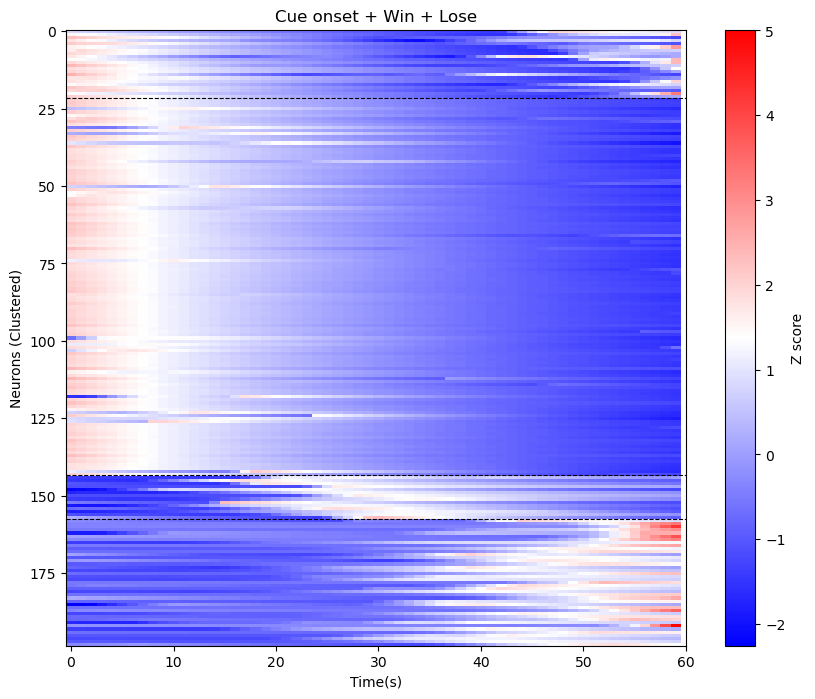

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

data_tobe_clustered = z_scored_mean_neural_acitivities_win

# Compute the distance matrix and perform hierarchical clustering
distance_matrix = pdist(data_tobe_clustered, metric='euclidean')
linkage_matrix = linkage(distance_matrix, method='ward')

# Get cluster labels
threshold = 30 # Adjust based on your dendrogram
clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# Reorder data by cluster labels
sorted_indices = np.argsort(clusters)  # Sort neurons by their cluster labels
data_sorted = data_tobe_clustered[sorted_indices]  # Reorder rows based on clustering

# Plot the heatmap
time_range = (-2,2,120)
plt.figure(figsize=(10, 8))
plt.imshow(data_sorted, aspect='auto', cmap='bwr', interpolation='nearest')
plt.colorbar(label='Z score')
plt.xticks(ticks=np.linspace(0, data_tobe_clustered.shape[1], 7))
# Add dashed lines to distinguish clusters
unique_clusters = np.unique(clusters)
for i in range(1, len(unique_clusters)):
    cluster_end = np.where(clusters[sorted_indices] == unique_clusters[i - 1])[0][-1]
    plt.axhline(y=cluster_end + 0.5, color='black', linestyle='--', linewidth=0.8)
plt.title("Cue onset + Win + Lose")
plt.xlabel("Time(s)")
plt.ylabel("Neurons (Clustered)")
# Save the heatmap in high quality
plt.savefig(f"/Users/fgs/HMLworkplace/Arena_analysis/Results_temp/concatenated.png", dpi=300, bbox_inches='tight')
plt.show()